# Cross-Validation & Grid Search

In [1]:
import pandas as pd

In [2]:
%load_ext autotime

time: 94.9 µs (started: 2022-07-09 22:40:17 +05:30)


In [3]:
df = pd.read_csv("data/home-credit-default-risk.csv",
                 usecols=["SK_ID_CURR", "TARGET", "NAME_CONTRACT_TYPE", "CODE_GENDER",
                            "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN", "AMT_INCOME_TOTAL",
                            "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"
                            ], index_col="SK_ID_CURR")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
SK_ID_CURR,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0


time: 788 ms (started: 2022-07-09 22:40:17 +05:30)


In [4]:
df["TARGET"].value_counts(normalize=True)

0    0.905533
1    0.094467
Name: TARGET, dtype: float64

time: 2.29 ms (started: 2022-07-09 22:40:17 +05:30)


## Feature Extraction / Transformations

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

y = df.pop("TARGET")
ct = ColumnTransformer([("l_enc", OneHotEncoder(), 
                            ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]), 
                        ("scaler", "passthrough", 
                            ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "CNT_CHILDREN"])])

X = ct.fit_transform(df)

time: 257 ms (started: 2022-07-09 22:40:17 +05:30)


## Conventional Stratified Splitting

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y)

time: 54.8 ms (started: 2022-07-09 22:40:18 +05:30)


In [7]:
from sklearn.tree import DecisionTreeClassifier

time: 20.5 ms (started: 2022-07-09 22:40:18 +05:30)


In [8]:
dt = DecisionTreeClassifier()

time: 156 µs (started: 2022-07-09 22:40:18 +05:30)


In [9]:
dt.fit(xtrain, ytrain)

DecisionTreeClassifier()

time: 572 ms (started: 2022-07-09 22:40:18 +05:30)


### Scoring on training data

In [10]:
roc_auc_score(ytrain, dt.predict(xtrain))

0.9182564832180042

time: 50.8 ms (started: 2022-07-09 22:40:18 +05:30)


### Scoring on testing data

In [11]:
roc_auc_score(ytest, dt.predict(xtest))

0.503541711317845

time: 24.6 ms (started: 2022-07-09 22:40:19 +05:30)


In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)  # shuffle=True is default
dt.fit(xtrain, ytrain)
print("Train score:", roc_auc_score(ytrain, dt.predict(xtrain)))
print("Test score:", roc_auc_score(ytest, dt.predict(xtest)))

Train score: 0.9188708530039449
Test score: 0.49922471154379616
time: 669 ms (started: 2022-07-09 22:40:19 +05:30)


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

time: 322 ms (started: 2022-07-09 22:40:19 +05:30)


### Let"s do it ten times

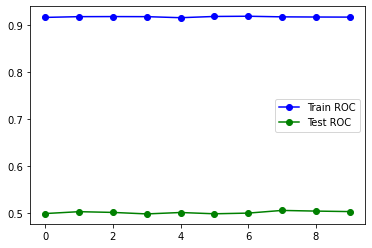

time: 6.81 s (started: 2022-07-09 22:40:20 +05:30)


In [14]:
train_scores = []
test_scores = []
for i in range(10):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)  # shuffle=True is default
    dt.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt.predict(xtest)))
plt.plot(train_scores, "-bo", label="Train ROC")
plt.plot(test_scores, "-go", label="Test ROC")
plt.legend()

## K-Fold Cross Validation

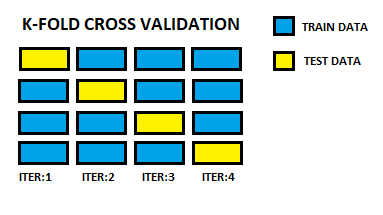

time: 1.88 ms (started: 2022-07-09 22:40:26 +05:30)


In [15]:
from IPython.display import Image
Image(filename="data/images/kfold.png")

In [16]:
from sklearn.model_selection import StratifiedKFold

time: 177 µs (started: 2022-07-09 22:40:26 +05:30)


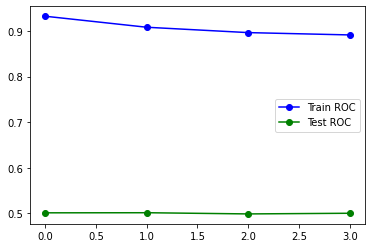

time: 2.9 s (started: 2022-07-09 22:40:26 +05:30)


In [17]:
skf = StratifiedKFold(n_splits=4)
train_scores = []
test_scores = []
for train_ix, test_ix in skf.split(X, y):
    xtrain, xtest, ytrain, ytest = X[train_ix], X[test_ix], y.iloc[train_ix], y.iloc[test_ix]
    dt.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt.predict(xtest)))
plt.plot(train_scores, "-bo", label="Train ROC")
plt.plot(test_scores, "-go", label="Test ROC")
plt.legend()

### Remember that we haven"t touched the model yet!

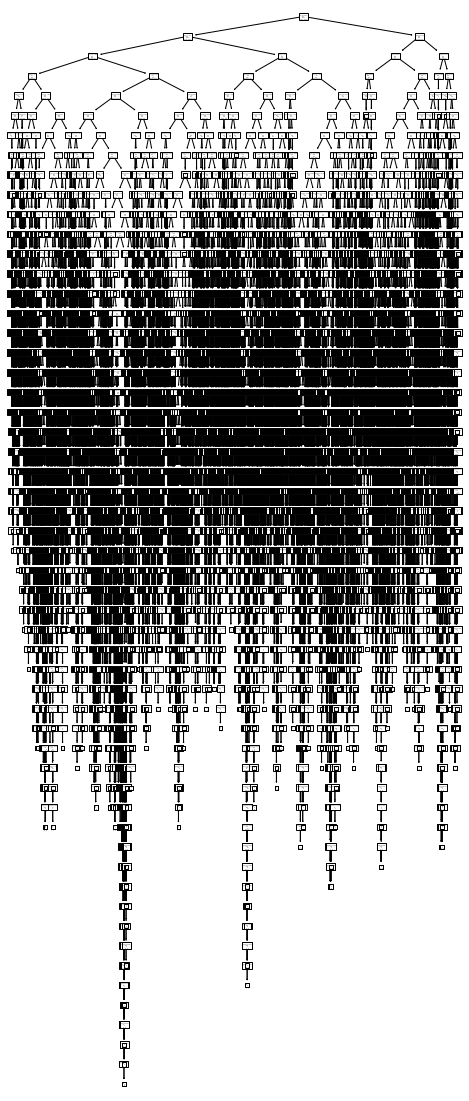

time: 3.29 ms (started: 2022-07-09 22:40:29 +05:30)


In [18]:
from IPython.display import Image
Image(filename="data/images/tree.png") 

## Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV
grid = {
    "criterion": ["gini", "entropy"],
    "splitter" : ["best", "random"],
    "max_depth": [10, 20, 30, 40, 50],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [2, 3, 4, 5],
    "class_weight": ["balanced"]
}

time: 305 µs (started: 2022-07-09 22:40:29 +05:30)


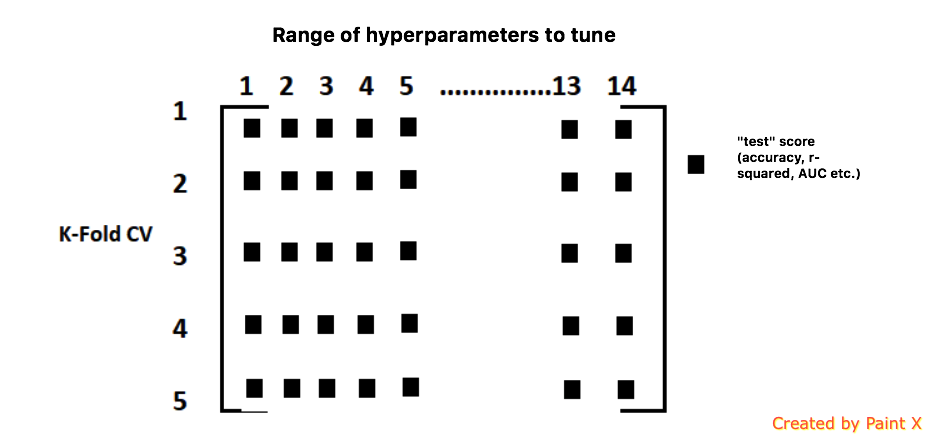

time: 1.73 ms (started: 2022-07-09 22:40:29 +05:30)


In [20]:
Image(filename="data/images/grid_search.png") 

In [21]:
gcv = GridSearchCV(DecisionTreeClassifier(), grid, scoring="roc_auc", cv=4, n_jobs=-1, verbose=2)

time: 213 µs (started: 2022-07-09 22:40:30 +05:30)


In [22]:
gcv.fit(X, y)

Fitting 4 folds for each of 240 candidates, totalling 960 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_split=2, splitter=random; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_split=2, splitter=random; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_split=2, splitter=random; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_split=2, splitter=best; total time=   0.2s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_split=2, splitter=random; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_split=2, splitter=best; total time=   0.2s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, min_samples_split=2, splitter=be

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5],
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=2)

time: 47.1 s (started: 2022-07-09 22:40:30 +05:30)


In [23]:
gcv.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 3,
 'splitter': 'best'}

time: 956 µs (started: 2022-07-09 22:41:17 +05:30)


In [24]:
dt_best = gcv.best_estimator_

time: 189 µs (started: 2022-07-09 22:41:17 +05:30)


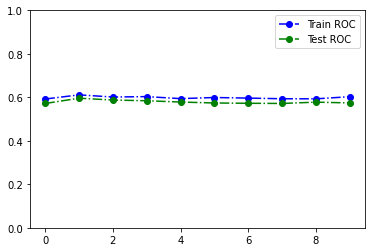

time: 1.89 s (started: 2022-07-09 22:41:17 +05:30)


In [25]:
skf = StratifiedKFold(n_splits=10)
train_scores = []
test_scores = []
for train_ix, test_ix in skf.split(X, y):
    xtrain, xtest, ytrain, ytest = X[train_ix], X[test_ix], y.iloc[train_ix], y.iloc[test_ix]
    dt_best.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt_best.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt_best.predict(xtest)))
plt.plot(train_scores, "-.bo", label="Train ROC")
plt.plot(test_scores, "-.go", label="Test ROC")
plt.ylim(0, 1)
plt.legend()

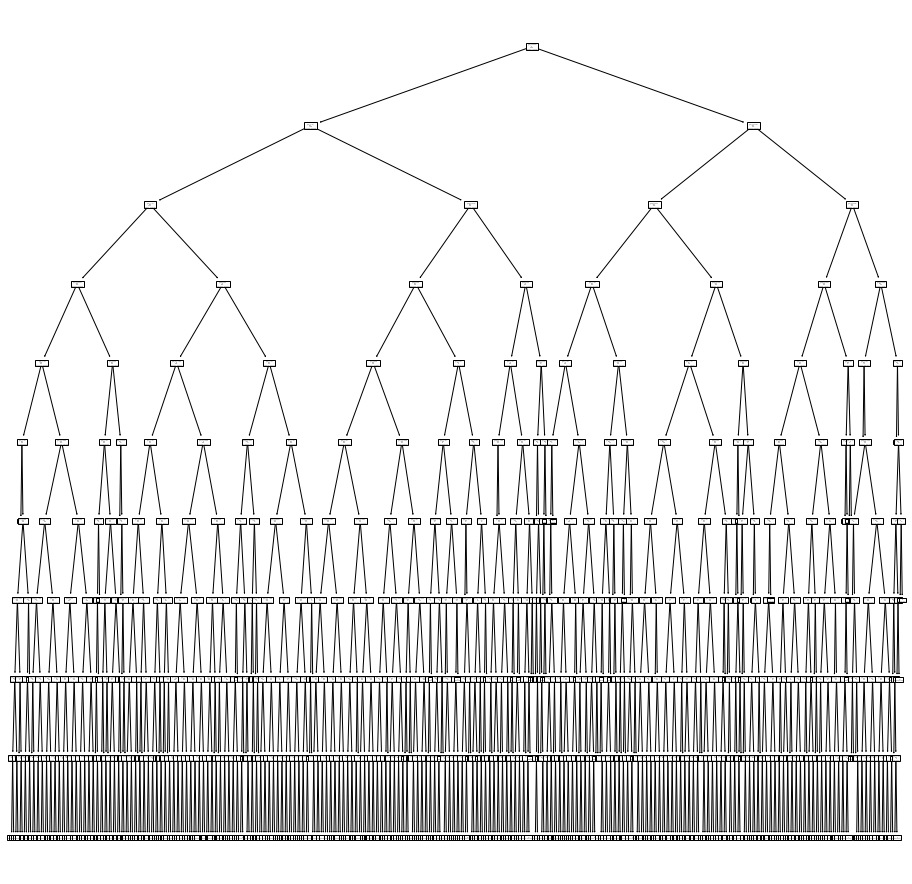

time: 4.94 ms (started: 2022-07-09 22:41:19 +05:30)


In [26]:
Image(filename="data/images/best_tree.png")

In [27]:
%unload_ext autotime